In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [2]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [37]:
both_res = parse_results('grid_search_results/both_wide_400.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]

In [38]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((45, 3, 400), (45, 3, 400))

In [39]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))
# SEEDS = sorted(list(set([p['subset_seed'] for p in hyp_params]).union(set([p['subset_seed'] for p in euc_params]))))

In [40]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)
# print(SEEDS)

[1, 2, 4, 8, 16]
[2, 4, 8, 16, 32, 64, 128, 196, 256]
[0.02]
[0.004]


In [41]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))
# num_seeds = len(SEEDS)

In [42]:
num_hidden_layers, layer_size

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  8,  8,  8,  8,  8,  8,  8,
         8,  8, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
 array([  2,   4,   8,  16,  32,  64, 128, 196, 256,   2,   4,   8,  16,
         32,  64, 128, 196, 256,   2,   4,   8,  16,  32,  64, 128, 196,
        256,   2,   4,   8,  16,  32,  64, 128, 196, 256,   2,   4,   8,
         16,  32,  64, 128, 196, 256]))

In [43]:
# if len(SEEDS) > 0:
#     hyp_values = np.array([v for _, v in hyp_res])
#     euc_values = np.array([v for _, v in euc_res])

#     hyp_seed_mean_values = []
#     euc_seed_mean_values = []
#     for i in range(len(hyp_values)//num_seeds):
#         hyp_seed_mean_values.append(np.mean(hyp_values[i*num_seeds:(i+1)*num_seeds], axis=0))
#         euc_seed_mean_values.append(np.mean(euc_values[i*num_seeds:(i+1)*num_seeds], axis=0))

#     hyp_values = np.array(hyp_seed_mean_values)
#     euc_values = np.array(euc_seed_mean_values)

--------------- Weight Decay: 0.004 ---------------


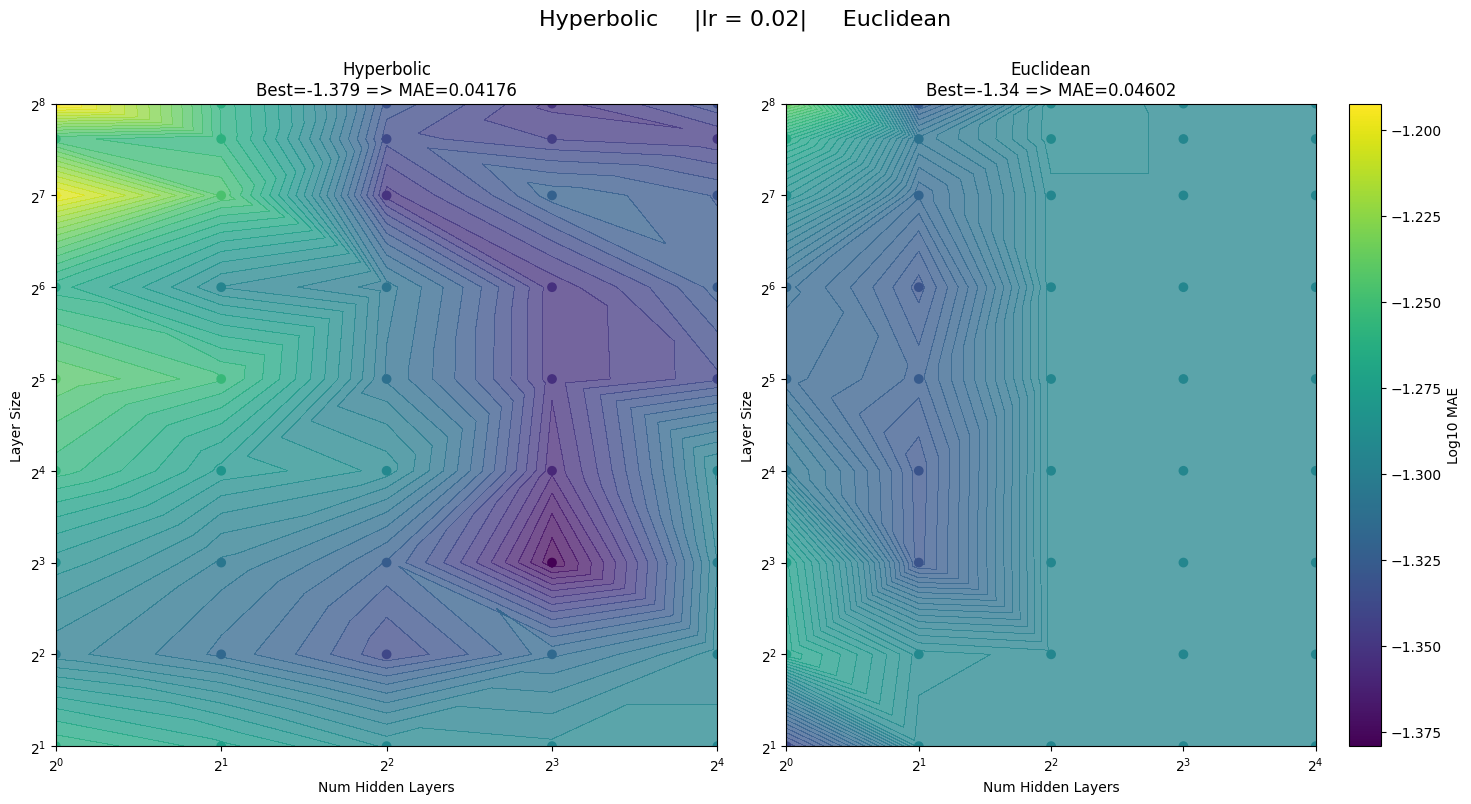

In [44]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = np.log10(hyp_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])
        euc_data = np.log10(euc_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic\nBest={np.min(hyp_data):.3f} => MAE={np.power(10, np.min(hyp_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='Log10 MAE')


        plt.title(f'Euclidean\nBest={np.min(euc_data):.3} => MAE={np.power(10, np.min(euc_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>Best Runs:</h3>
Checked every 100 epochs, bc taking the min epoch gives advantage to unstable training.

Hyperbolic:  MAE = 0.040 (80 EPOCHS)
- num-l: 4
- size-l: 64
- lr: 0.02
- wd: 0.004

Euclidean:  MAE = (X EPOCHS)
- num-l: 2
- size-l: 64
- lr: 0.02
- wd: 0.005

<h2>Single run with 'average' random sample</h2> 
<h3>1</h3>

- Hyp: 0.040; 16,64
- Euc: 0.043; 1,64

<h3>1/2</h3>

- Hyp: 0.036; 8,128; 0.02,0.003; 199
- Euc: 0.038; 1,2; 0.01,0.005; 199

<h3>1/4</h3>

- Hyp: 0.042; 8,8; 0.02,0.004; 49
- Euc: 0.034; 1,16; 0.01,0.005; 39

<h3>1/6</h3>

- Hyp: 0.036; 1,2; 0.02,0.003; 99
- Euc: 0.037; 1,2; 0.005,0.005; 99

<h3>1/8</h3>

- Hyp: 0.022; 16,64; 0.005,0.005; 199
- Euc: 0.032; 1,2; 0.005,0.003; 199


<h2>10 random seeds with growing validation set</h2>

- lr = 0.01
- wd = 0.004
- epochs = 200
 
<h3>1</h3>

- Hyp: 0.0429; 16,8
- Euc: 0.0434; 1,64

<h3>1/2</h3>

- Hyp: 0.0461; 16,8
- Euc: 0.0447; 1,16

<h3>1/4</h3>

- Hyp: 0.0483; 16,8
- Euc: 0.0466, 1,16 (49)

<h3>1/8</h3>

- Hyp: 0.0562; 16,2
- Euc: 0.0498; 1,16 (49)

<h2>Take subsets of normal cross-val train-indices, always same val-set</h2>

 
<h3>1</h3>

- Hyp: 0.041; 4,64; 0.02,0.004 (99) 
- Euc: 0.044; 1,2;  0.02,0.008 (99)

<h3>1/2</h3>

- Hyp: 0.041; 16,64; 0.01,0.008 (199)
- Euc: 0.044; 1,64, 0.001,0.008 (199)

<h3>1/3</h3>

- Hyp: 0.047; 16,8; 0.01,0.008 (99)
- Euc: 0.046; 4,8; 0.05,0.004 (99)

<h3>1/4</h3>

- Hyp: 0.043; 8,64; 0.02,0.008 (99)
- Euc: 0.042, 4,128; 0.02,0.002 (99)

<!-- <h3>1/6</h3>

- Hyp: 0.048; 4,64; 0.02,0.002 (99)
- Euc: 0.042; 4,128; 0.02,0.002 (199) -->

<h3>1/8</h3>

- Hyp: 0.042; 8,64; 0.02,0.008 (99)
- Euc: 0.045; 4,2; 0.01,0.002 (99)

In [45]:
K = 49

best_hyp_params = np.argsort(hyp_values.mean(axis=1)[:,K])[:8]
print(hyp_values.mean(axis=1)[:,K][best_hyp_params])
print()
best_euc_params = np.argsort(euc_values.mean(axis=1)[:,K])[:8]
print(euc_values.mean(axis=1)[:,K][best_euc_params])

best_hyp_runs = hyp_values.mean(axis=1)[best_hyp_params]
best_euc_runs = euc_values.mean(axis=1)[best_euc_params]

[0.04291301 0.04397815 0.04424358 0.04536088 0.04552434 0.04626344
 0.04724369 0.04735371]

[0.04243231 0.0438169  0.04438296 0.04496297 0.04501974 0.04509571
 0.0456553  0.04619343]


In [46]:
print(hyp_params[best_hyp_params])
print()
print(euc_params[best_euc_params])

[{'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 4, 'layer_size': 64, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 256, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 128, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 400, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 64, 'lr': 0.02, 'weig

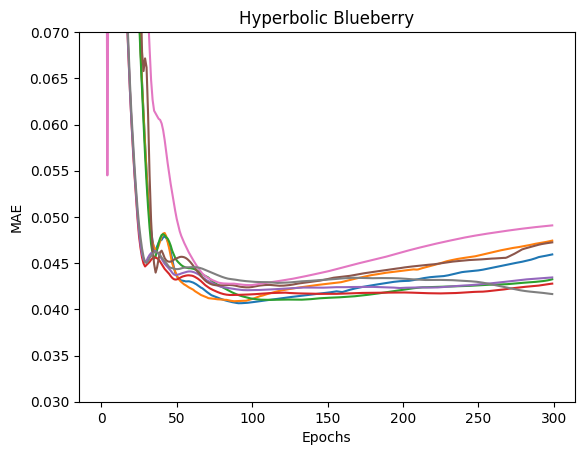

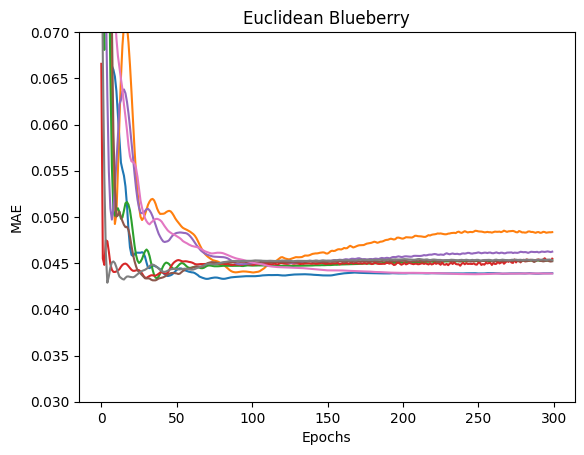

In [26]:
for run in hyp_values.mean(axis=1)[best_hyp_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[best_euc_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()
